# Homework 2

In [51]:
import os
import time
import sklearn
import numpy as np
import pandas as pd
import surprise
import seaborn as sns
import matplotlib.pyplot as plt

from utility import *
from scipy import stats
from surprise import NMF
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from collections import defaultdict
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
%matplotlib inline

## Part 1: Business Objectives

**1. Your objective function**
- The objective function of this recommendation system is to increase users' experience/stickiness and ultimately their time spent on our site by making their search for the movies easier as well as by making them consistenly interested in our movie inventory. To achieve that, the recommendation system will provide a list of five movies to the users every time they log in, and the recommendation list will be a combination of movies that are most relevant to the users as well as the movies that are novel to the users.

**2. Any metric you wish to optimize in addition to accuracy**
- To echo back to the objective of our recommendation system, we will use item-coverage and novelty as the two metrics we optimize in addition to accuracy.

**3. The intended user**
- As a core piece of the user experience uplift strategy, this recommendation system intends to serve all users coming to our site to search for movies to watch, which means this recommendation system should be able to make recommendations to both new users and existing users. 

**4. Any business rules you think will be important**
- Never recommend items with less than 20% popularity. Our overall strategy will be to "discard" the movies that are the least popular, "maintain" the movies that are the most popular, and "boost" the movies that are in the middle of the popularity spectrum.
- Always include the most popular movies in the recommendation to users who are at the bottom 25% in terms of activeness(measured by the number of movies rated). This will serve as a baseline cold-start strategy.
- Always recommend movies that the users have started but haven't finished if the relevant user data is accessible.
- Always recommend movies that are trending now. For example, recommend romance movies during Valentine's Day.
- Always include some level of novelty in the recommendations, meaning movies from different genres.

**5. Performance requirements**
- The time complexity of rating making should be O(kN), where N denotes the number of movie items.

## Part 2: Two models building

In [57]:
# load the data set for full ratings
ratings = pd.read_csv('/Users/weixiyao/desktop/PERS_HW2/ml-latest/ratings.csv', 
                      usecols=['userId', 'movieId', 'rating'],
                      dtype={'user|Id':'int32', 'movieId':'int32', 'rating':'float128'},
                      sep=',')

print("number of distinct participated users: ", ratings['userId'].nunique())
print("number of distinct rated movies: ", ratings['movieId'].nunique())

number of distinct participated users:  283228
number of distinct rated movies:  53889


For experiment and development purposes, we will extract a small subset of users and movie items from the "full" dataset.

We will first select ~1000 items and ~25000 users for model development and we will then select ~200 items and ~1500 users from the development set for testing purposes.

The methodology of selecting these users and items will be discussed in the data exploration section.

**Data exploration and dataset sampling**

Understanding how the data is distributed is crucial for designing the subsampling strategy and we believe that, in a real world setting, data collected from explicit feedbacks like ratings can be very sparse and data points are mostly collected from very popular movies and highly active users.

The following data exploration will justify our hypothesis.

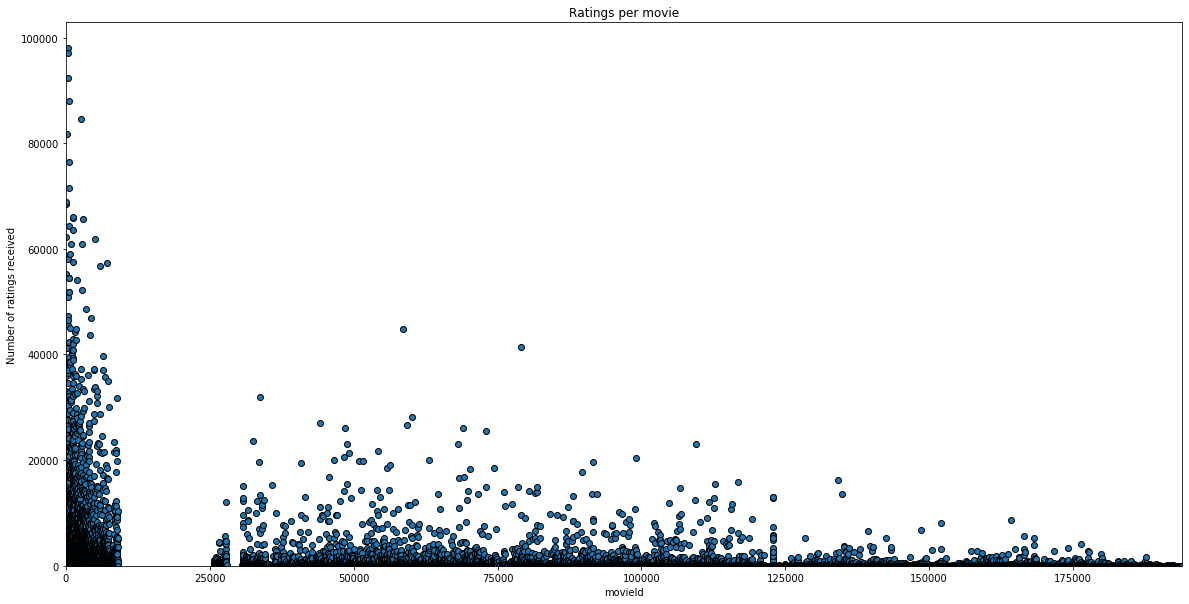

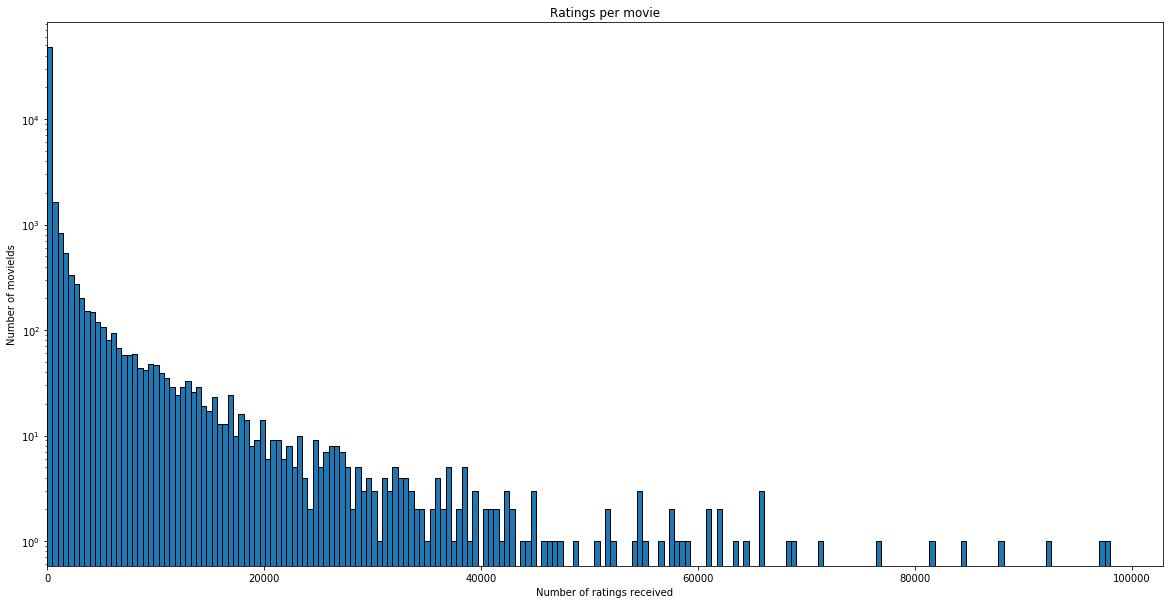

In [58]:
# visualize the popularity by each movie
movie_popularity = ratings[['userId', 'movieId']].groupby('movieId').count()
movie_popularity.columns=['num_ratings']
plt.figure(figsize=(20, 10))
plt.scatter(movie_popularity.index, 
            movie_popularity.num_ratings, 
            edgecolor='black')
plt.xlim(0, movie_popularity.index.max())
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

# visualize the distribution of the popularity across all movies
plt.figure(figsize=(20, 10))
plt.hist(movie_popularity.num_ratings, 
         bins=200, 
         edgecolor='black', 
         log=True)
plt.title('Ratings per movie')
plt.xlabel('Number of ratings received')
plt.ylabel('Number of movieIds')
plt.xlim(0,)
plt.show()

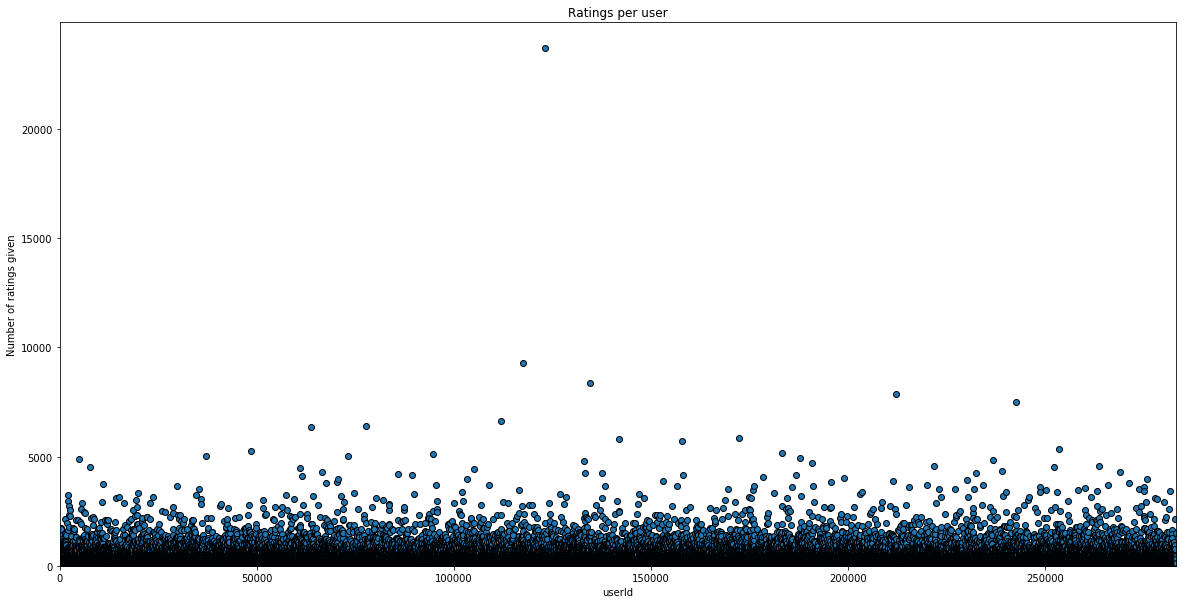

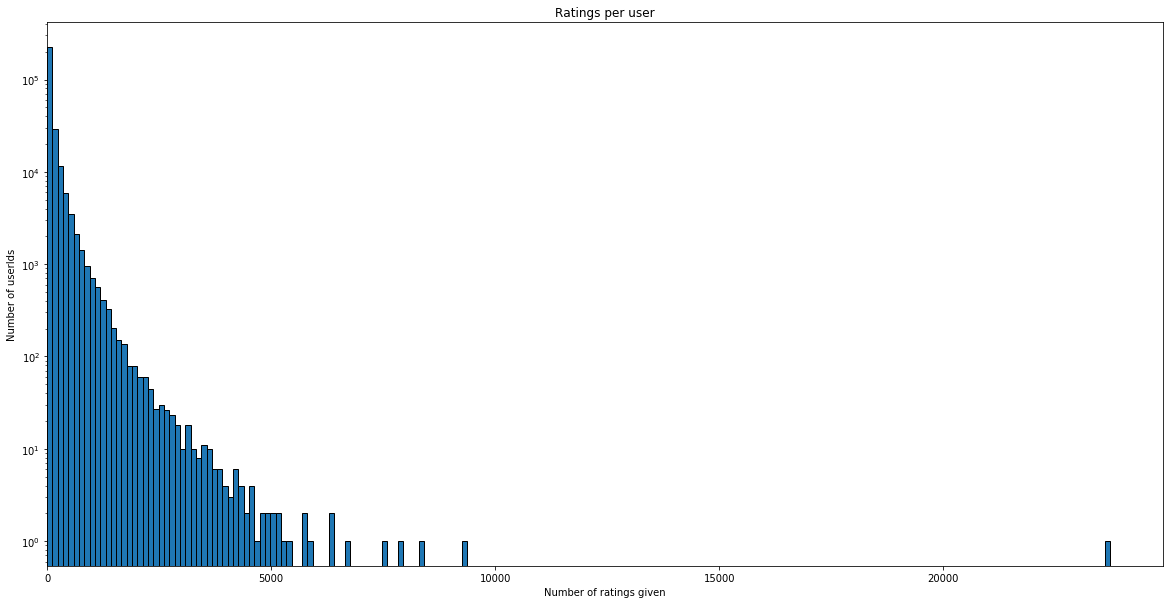

In [59]:
# visualize the popularity by each movie
user_activeness = ratings[['userId', 'movieId']].groupby('userId').count()
user_activeness.columns=['num_ratings']
plt.figure(figsize=(20, 10))
plt.scatter(user_activeness.index, 
            user_activeness.num_ratings, 
            edgecolor='black')
plt.xlim(0, user_activeness.index.max())
plt.ylim(0,)
plt.title('Ratings per user')
plt.xlabel('userId')
plt.ylabel('Number of ratings given')
plt.show()

# visualize the distribution of the popularity across all movies
plt.figure(figsize=(20, 10))
plt.hist(user_activeness.num_ratings, 
         bins=200, 
         edgecolor='black', 
         log=True)
plt.title('Ratings per user')
plt.xlabel('Number of ratings given')
plt.ylabel('Number of userIds')
plt.xlim(0,)
plt.show()

- The graphs above preliminarily confirm our assumptions regarding the distribution of the number of ratings received per movie and the distribution of the number of ratings given per user, which are two extremely long-tailed distributions. Based on this observation, we ideally want to draw a subset of movie items and users that can represent the original dataset without giving unrealistically good or bad experiment results.


- We specifically want to get rid of the movies whose popularity is at the bottom 50 percentile, because we believe that there is a high possibility that those movies are only favored by an extremely small group of users, and more importantly, that the average ratings received by those movies are more likely to be biased. The same strategy also applies to users.


- For example, if certain movies are rated only once and received an average rating of 5, in an item-based collaborative filtering model, those movies will accidentally become part of the recommendations for many if not all users, which is not ideal. 

**Create a subset of dataset, save it for performance measurement**

In [53]:
ratings_full = sample_dateset_by_percentile(ratings, 25000, 1000)
print("number of distinct participated users (full): ", ratings_full['userId'].nunique())
print("number of distinct rated movies (full): ", ratings_full['movieId'].nunique())

number of distinct participated users (full):  24511
number of distinct rated movies (full):  1000


In [54]:
reader = Reader()
data_full = Dataset.load_from_df(ratings_full[['userId', 
                                               'movieId', 
                                               'rating']], 
                                 reader=reader)

**Create a subset of dataset, save it for development**

In [55]:
ratings_sub = sample_dateset_by_percentile(ratings_full, 1500, 200)
print("number of distinct participated users (subset): ", ratings_sub['userId'].nunique())
print("number of distinct rated movies (subset): ", ratings_sub['movieId'].nunique())

number of distinct participated users (subset):  1487
number of distinct rated movies (subset):  200


In [56]:
reader = Reader()
data_sub = Dataset.load_from_df(ratings_sub[['userId', 
                                             'movieId', 
                                             'rating']], 
                                reader=reader)

After careful manipulation, we have successfully keep 1487 users from top active levels and 200 movie items from top popularity levels, for development purposes.

### Part 2.1: Item-based neighborhood method

In [61]:
trainvalset, testset = train_test_split(data_sub, test_size=0.2)

In [68]:
# baseline modeling constructing
item_model = KNNWithMeans(k=4, sim_options={'name': 'pearson', 
                                            'user_based': False, 
                                            'verbose' : False})

In [63]:
item_model.fit(trainvalset);

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [64]:
uid = str(699)
iid = str(296)
item_model_pred = item_model.predict(uid, 
                                     iid, 
                                     verbose=False)
print("Prediction for rating: ", item_model_pred)

Prediction for rating:  user: 699        item: 296        r_ui = None   est = 3.50   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


- In this project, we’ll use the surprise package, a popular package for building recommendation systems in Python. 

- At this part, we have sucessfully built and tested a baseline item-based neighborhood model by making a demo rating pradiction for user 699 and item 296.

- The item-based neighborhood model built above uses pearson as the similarity metric and considers the ratings of four closest neighbors while making predictions.

### Part 2.2: Matrix Factorization

In [69]:
# baseline model constructing
NMF_model = NMF(n_factors=20, 
                n_epochs=10, 
                biased=True)

In [66]:
NMF_model.fit(trainvalset);

In [67]:
uid = str(699)
iid = str(296)
NMF_model_pred = NMF_model.predict(uid, 
                                   iid,
                                   verbose=False)
print("Prediction for rating: ", NMF_model_pred)

Prediction for rating:  user: 699        item: 296        r_ui = None   est = 3.50   {'was_impossible': False}


- At this part, we have sucessfully built and tested a baseline matrix factorization model(NMF) by making a demo rating pradiction for user 699 and item 296.

- The NMF model built above decomposes the characteristic matrix in latent space size of 20.

## Part 3: Model evaluation

### Part 3.1.1: CV setup for item-based neighborhood method

For this task, we will use **RMSE(Root Mean Squared Error)** as the primary accuracy metric and **MAE(Mean Absolute Error)** as the secondary accuracy metric.

In [70]:
# Run 5-fold cross-validation and print results
result = cross_validate(item_model, 
                        data_full, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9494  0.9502  0.9489  0.9580  0.9488  0.9511  0.0035  
MAE (testset)     0.7170  0.7186  0.7161  0.7226  0.7174  0.7183  0.0023  
RMSE (trainset)   0.4191  0.4172  0.4189  0.4180  0.4169  0.4180  0.0009  
MAE (trainset)    0.3132  0.3118  0.3131  0.3126  0.3117  0.3125  0.0006  
Fit time          0.71    0.81    0.77    0.81    0.75    0.77    0.04    
Test time         2.22    2.97    2.17    1.75    2.16    2.26    0.40    


The results above give an preliminary review of how well the model fits the training set as well as how well the model generalizes on the test set. According to the results above, the **average testset RMSE is 0.95** and the **average testset MAE is 0.71**.

### Part 3.1.2: Coverage of item-based neighborhood method

In [71]:
trainvalset, testset = train_test_split(data_sub, test_size=0.2)
trainvalset_testfy = trainvalset.build_anti_testset()

In [72]:
user_list_train = set(trainvalset.all_users())
user_list_test = set([item[0] for item in testset])

item_list_train = set(trainvalset.all_items())
item_list_test = set([item[1] for item in testset])

In [73]:
item_model.fit(trainvalset);

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [78]:
predictions_train = item_model.test(trainvalset_testfy)
predictions_test = item_model.test(testset)

top_n_train = get_top_n(predictions_train, n=1)
top_n_test = get_top_n(predictions_test, n=1)

In [79]:
recommendation_train = []
# Print the recommended items for each user
for uid, user_ratings in top_n_train.items():
    recommendation_train.append([iid for (iid, _) in user_ratings])
    
recommendation_train_list = []
for rec_list in recommendation_train:
    for item in rec_list:
        recommendation_train_list.append(item)
recommendation_train_list = set(recommendation_train_list)

In [80]:
recommendation_test = []
# Print the recommended items for each user
for uid, user_ratings in top_n_test.items():
    recommendation_test.append([iid for (iid, _) in user_ratings])

recommendation_test_list = []
for rec_list in recommendation_test:
    for item in rec_list:
        recommendation_test_list.append(item)
recommendation_test_list = set(recommendation_test_list)

In [81]:
print('coverage on train set', '{:.2f}'.format(len(recommendation_train_list)/len(item_list_train)))
print('coverage on test set', '{:.2f}'.format(len(recommendation_test_list)/len(item_list_test)))

coverage on train set 0.25
coverage on test set 0.69


**Explanation:**

- xxx

- xxx

### Part 3.2.1: CV setup for Matrix Factorization

In [82]:
# Run 5-fold cross-validation and print results
result = cross_validate(NMF_model, 
                        data_full, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1466  1.1935  1.2727  1.1738  1.1380  1.1849  0.0481  
MAE (testset)     0.8672  0.9039  0.9661  0.8884  0.8603  0.8972  0.0378  
RMSE (trainset)   1.1337  1.1863  1.2443  1.1647  1.1252  1.1708  0.0427  
MAE (trainset)    0.8506  0.8934  0.9413  0.8767  0.8494  0.8823  0.0338  
Fit time          3.66    3.72    3.50    3.45    3.49    3.56    0.11    
Test time         0.41    0.42    0.38    0.96    1.02    0.64    0.29    


The results above give an preliminary review of how well the model fits the training set as well as how well the model generalizes on the test set. According to the results above, the **average testset RMSE is 1.18** and the **average testset MAE is 0.89**.

### Part 3.2.2: Coverage of Matrix Factorization

In [83]:
NMF_model.fit(trainvalset);

In [87]:
predictions_train = NMF_model.test(trainvalset_testfy)
predictions_test = NMF_model.test(testset)

top_n_train = get_top_n(predictions_train, n=1)
top_n_test = get_top_n(predictions_test, n=1)

In [88]:
recommendation_train = []
# Print the recommended items for each user
for uid, user_ratings in top_n_train.items():
    recommendation_train.append([iid for (iid, _) in user_ratings])
    
recommendation_train_list = []
for rec_list in recommendation_train:
    for item in rec_list:
        recommendation_train_list.append(item)
recommendation_train_list = set(recommendation_train_list)

In [89]:
recommendation_test = []
# Print the recommended items for each user
for uid, user_ratings in top_n_test.items():
    recommendation_test.append([iid for (iid, _) in user_ratings])
    
recommendation_test_list = []
for rec_list in recommendation_test:
    for item in rec_list:
        recommendation_test_list.append(item)
recommendation_test_list = set(recommendation_test_list)

In [90]:
print('coverage on train set', '{:.2f}'.format(len(recommendation_train_list)/len(item_list_train)))
print('coverage on test set', '{:.2f}'.format(len(recommendation_test_list)/len(item_list_test)))

coverage on train set 0.10
coverage on test set 0.74


**Explanation:**

- xxx

- xxx

## Part 4: GridSearch

### Part 4.1: GS setup for item-based neighborhood method

In [121]:
param_grid = {'k': [2, 6, 10, 14, 18, 20]}

In [122]:
gs = GridSearchCV(KNNWithMeans, 
                  param_grid, 
                  measures=['RMSE', 'MAE'], 
                  cv=5)

In [123]:
gs.fit(data_sub);

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [124]:
results_df = pd.DataFrame.from_dict(gs.cv_results)

In [125]:
n_k = results_df['param_k']
mae_results = results_df['mean_test_mae']
rmse_results = results_df['mean_test_rmse']

In [126]:
# best RMSE score
print('Best RMSE', '{:f}'.format(gs.best_score['rmse']))
print('BEST MAE', '{:f}'.format(gs.best_score['mae']))

Best RMSE 0.995994
BEST MAE 0.768562


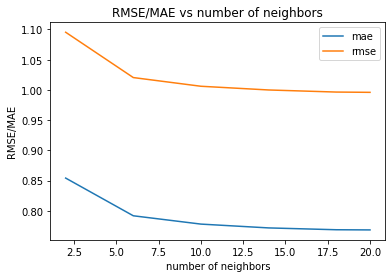

In [127]:
fig, ax = plt.subplots()
ax.plot(n_k, mae_results, label='mae');
ax.plot(n_k, rmse_results, label='rmse');
ax.set_title('RMSE/MAE vs number of neighbors')
ax.set_xlabel('number of neighbors')
ax.set_ylabel('RMSE/MAE')
ax.legend();

**Explanation:**
- As we can see from the results above, as the number of neighbors increases, both of the accuracy measures decrease. This makes sense because as the model considers more items(neighbors) while making predictions, the model becomes more capable of making more accurate predictions.
- Although we haven't reached the optimal RMSE/MAE in this grid, we would say the **best number of neighbors is 15** because after 15 the drop of RMSE/MAE significantly slows down.

### Part 4.2: GS setup for Matrix Factorization

In [107]:
param_grid = {'n_factors': [10, 30, 50, 70, 90]}

In [108]:
gs = GridSearchCV(NMF, 
                  param_grid, 
                  measures=['RMSE', 'MAE'], 
                  cv=5)

In [109]:
gs.fit(data_sub)

In [110]:
results_df = pd.DataFrame.from_dict(gs.cv_results)

In [111]:
n_factors = results_df['param_n_factors']
mae_results = results_df['mean_test_mae']
rmse_results = results_df['mean_test_rmse']

In [112]:
# best RMSE score
print('Best RMSE', '{:f}'.format(gs.best_score['rmse']))
print('BEST MAE', '{:f}'.format(gs.best_score['mae']))

Best RMSE 1.016368
BEST MAE 0.772929


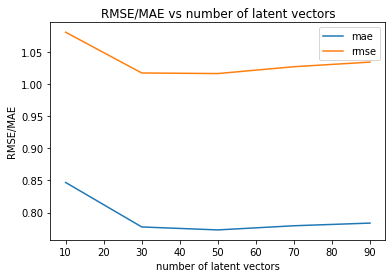

In [113]:
fig, ax = plt.subplots()
ax.plot(n_factors, mae_results, label='mae');
ax.plot(n_factors, rmse_results, label='rmse');
ax.set_title('RMSE/MAE vs number of latent vectors')
ax.set_xlabel('number of latent vectors')
ax.set_ylabel('RMSE/MAE')
ax.legend();

**Explanation:**
- As we can see from the results above, as the number of latent vectors increases, both of the accuracy measures decrease. This makes sense because the matrix factorization algorithm re-constructs the true matrix more accurately with higher latent vector size.

- **The best size of latent space is 30**

## Part 5: Other design

There are two key observations arise from the above section:

1. Models with higher complexity usually perform better.
    - According to the grid-search results, the "accuracy" of the models increase as the number of latent vectors/number of neightbos increase. Therefore, if we want to further increase the accuracy of the baseline models built previously, we should definitely construct models with reasonably high complexity.


2. The test set's coverage of the more "accurate" model is lower.
    - xxx
 

## Part 6: Sample size modification

### Part 6.1: 25%

In [251]:
ratings_25 = sample_dateset_by_percentile(ratings, 8000, 250)
print("number of distinct participated users (full): ", ratings_25['userId'].nunique())
print("number of distinct rated movies (full): ", ratings_25['movieId'].nunique())

number of distinct participated users (full):  6370
number of distinct rated movies (full):  250


In [252]:
reader = Reader()
data_25 = Dataset.load_from_df(ratings_25[['userId', 
                                           'movieId', 
                                           'rating']], 
                               reader=reader)

**rebuild the model using the best paramter**

In [253]:
# rebuild the model using the best paramter
item_model = KNNWithMeans(k=15, 
                          sim_options={'name': 'pearson', 
                                       'user_based': False, 
                                       'verbose' : False})

In [254]:
# rebuild the model using the best paramter
NMF_model = NMF(n_factors=30, 
                n_epochs=10, 
                biased=True)

### Part 6.1.1: Performance of item-based neighborhood method at 25% sampling size

In [255]:
result = cross_validate(item_model, 
                        data_25, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0098  0.9871  1.0034  0.9861  1.0016  0.9976  0.0094  
MAE (testset)     0.7628  0.7410  0.7533  0.7461  0.7591  0.7525  0.0081  
RMSE (trainset)   0.4358  0.4384  0.4313  0.4353  0.4353  0.4352  0.0023  
MAE (trainset)    0.3048  0.3062  0.3011  0.3043  0.3043  0.3041  0.0017  
Fit time          0.04    0.05    0.05    0.05    0.05    0.05    0.00    
Test time         0.14    0.13    0.13    0.13    0.14    0.13    0.00    


In [256]:
item_model_25_fit_time = np.sum(result['fit_time'])/len(result['fit_time'])
item_model_25_test_time = np.sum(result['test_time'])/len(result['test_time'])

In [257]:
item_model_25_rmse = np.sum(result['test_rmse'])/len(result['test_rmse'])
item_model_25_mae = np.sum(result['test_mae'])/len(result['test_mae'])

### Part 6.1.2: Performance of Matrix Factroization at 25% sampling size

In [258]:
result = cross_validate(NMF_model, 
                        data_25, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4285  1.4861  1.4817  1.3912  1.3343  1.4244  0.0571  
MAE (testset)     1.1089  1.1827  1.1454  1.0807  1.0218  1.1079  0.0551  
RMSE (trainset)   1.4141  1.4923  1.4808  1.3792  1.3360  1.4205  0.0595  
MAE (trainset)    1.0872  1.1681  1.1423  1.0563  1.0253  1.0958  0.0529  
Fit time          0.63    0.62    0.59    0.58    0.57    0.60    0.02    
Test time         0.04    0.04    0.04    0.04    0.04    0.04    0.00    


In [259]:
NMF_model_25_fit_time = np.sum(result['fit_time'])/len(result['fit_time'])
NMF_model_25_test_time = np.sum(result['test_time'])/len(result['test_time'])

In [260]:
NMF_model_25_rmse = np.sum(result['test_rmse'])/len(result['test_rmse'])
NMF_model_25_mae = np.sum(result['test_mae'])/len(result['test_mae'])

### Part 6.2: 50%

In [261]:
ratings_50 = sample_dateset_by_percentile(ratings, 13000, 500)
print("number of distinct participated users (full): ", ratings_50['userId'].nunique())
print("number of distinct rated movies (full): ", ratings_50['movieId'].nunique())

number of distinct participated users (full):  12131
number of distinct rated movies (full):  500


In [262]:
reader = Reader()
data_50 = Dataset.load_from_df(ratings_50[['userId', 
                                           'movieId', 
                                           'rating']], 
                               reader=reader)

### Part 6.2.1: Performance of item-based neighborhood method at 50% sampling size

In [263]:
result = cross_validate(item_model, 
                        data_50, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9298  0.9294  0.9343  0.9281  0.9417  0.9326  0.0050  
MAE (testset)     0.7072  0.7033  0.7084  0.7025  0.7159  0.7075  0.0048  
RMSE (trainset)   0.4893  0.4942  0.4944  0.4900  0.4921  0.4920  0.0021  
MAE (trainset)    0.3584  0.3620  0.3620  0.3592  0.3608  0.3605  0.0015  
Fit time          0.19    0.23    0.22    0.21    0.22    0.22    0.01    
Test time         1.23    0.66    0.65    0.63    0.64    0.76    0.23    


In [264]:
item_model_50_fit_time = np.sum(result['fit_time'])/len(result['fit_time'])
item_model_50_test_time = np.sum(result['test_time'])/len(result['test_time'])

In [265]:
item_model_50_rmse = np.sum(result['test_rmse'])/len(result['test_rmse'])
item_model_50_mae = np.sum(result['test_mae'])/len(result['test_mae'])

### Part 6.2.2: Performance of Matrix Factorization at 50% sampling size

In [266]:
result = cross_validate(NMF_model, 
                        data_50, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3238  1.4741  1.2383  1.6707  1.3311  1.4076  0.1518  
MAE (testset)     1.0182  1.1585  0.9527  1.3294  1.0153  1.0948  0.1353  
RMSE (trainset)   1.3299  1.4370  1.2335  1.6646  1.3225  1.3975  0.1483  
MAE (trainset)    1.0179  1.1193  0.9403  1.3255  1.0050  1.0816  0.1348  
Fit time          1.63    1.65    1.75    1.76    1.67    1.69    0.05    
Test time         0.77    0.14    0.15    0.14    0.14    0.27    0.25    


In [267]:
NMF_model_50_fit_time = np.sum(result['fit_time'])/len(result['fit_time'])
NMF_model_50_test_time = np.sum(result['test_time'])/len(result['test_time'])

In [268]:
NMF_model_50_rmse = np.sum(result['test_rmse'])/len(result['test_rmse'])
NMF_model_50_mae = np.sum(result['test_mae'])/len(result['test_mae'])

### Part 6.3: 75%

In [269]:
ratings_75 = sample_dateset_by_percentile(ratings, 19000, 750)
print("number of distinct participated users (full): ", ratings_75['userId'].nunique())
print("number of distinct rated movies (full): ", ratings_75['movieId'].nunique())

number of distinct participated users (full):  18377
number of distinct rated movies (full):  750


In [270]:
reader = Reader()
data_75 = Dataset.load_from_df(ratings_75[['userId', 
                                           'movieId', 
                                           'rating']], 
                               reader=reader)

### Part 6.3.1: Performance of item-based neighborhood method at 75% sampling size

In [271]:
result = cross_validate(item_model, 
                        data_75, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9264  0.9241  0.9281  0.9231  0.9250  0.9253  0.0018  
MAE (testset)     0.6964  0.6988  0.6971  0.6940  0.6968  0.6966  0.0015  
RMSE (trainset)   0.5150  0.5177  0.5139  0.5159  0.5161  0.5158  0.0013  
MAE (trainset)    0.3796  0.3825  0.3792  0.3807  0.3811  0.3806  0.0012  
Fit time          0.60    0.49    0.46    0.48    0.50    0.50    0.05    
Test time         2.34    1.45    1.48    1.94    1.43    1.73    0.36    


In [272]:
item_model_75_fit_time = np.sum(result['fit_time'])/len(result['fit_time'])
item_model_75_test_time = np.sum(result['test_time'])/len(result['test_time'])

In [273]:
item_model_75_rmse = np.sum(result['test_rmse'])/len(result['test_rmse'])
item_model_75_mae = np.sum(result['test_mae'])/len(result['test_mae'])

### Part 6.3.2: Performance of Matrix Factorization at 75% sampling size

In [274]:
result = cross_validate(NMF_model, 
                        data_75, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2147  1.2451  1.3294  1.2712  1.2098  1.2540  0.0437  
MAE (testset)     0.9204  0.9561  1.0071  0.9692  0.9175  0.9541  0.0332  
RMSE (trainset)   1.1938  1.2219  1.3231  1.2621  1.1918  1.2385  0.0494  
MAE (trainset)    0.9015  0.9328  0.9979  0.9550  0.9004  0.9375  0.0365  
Fit time          3.21    2.95    2.89    3.01    3.19    3.05    0.13    
Test time         0.27    0.86    0.25    0.27    0.28    0.39    0.24    


In [275]:
NMF_model_75_fit_time = np.sum(result['fit_time'])/len(result['fit_time'])
NMF_model_75_test_time = np.sum(result['test_time'])/len(result['test_time'])

In [276]:
NMF_model_75_rmse = np.sum(result['test_rmse'])/len(result['test_rmse'])
NMF_model_75_mae = np.sum(result['test_mae'])/len(result['test_mae'])

### Part 6.4: 100%

In [277]:
ratings_100 = sample_dateset_by_percentile(ratings, 25000, 1000)
print("number of distinct participated users (full): ", ratings_100['userId'].nunique())
print("number of distinct rated movies (full): ", ratings_100['movieId'].nunique())

number of distinct participated users (full):  24511
number of distinct rated movies (full):  1000


In [278]:
reader = Reader()
data_100 = Dataset.load_from_df(ratings_100[['userId', 
                                             'movieId', 
                                             'rating']], 
                                reader=reader)

### Part 6.4.1: Performance of item-based neighborhood method at 100% sampling size

In [279]:
result = cross_validate(item_model, 
                        data_100, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9122  0.9176  0.9130  0.9169  0.9178  0.9155  0.0024  
MAE (testset)     0.6893  0.6928  0.6914  0.6918  0.6941  0.6919  0.0016  
RMSE (trainset)   0.5211  0.5213  0.5231  0.5190  0.5202  0.5209  0.0014  
MAE (trainset)    0.3870  0.3868  0.3886  0.3855  0.3863  0.3869  0.0010  
Fit time          0.85    0.81    0.76    0.80    0.80    0.80    0.03    
Test time         2.43    2.28    2.27    2.27    2.84    2.42    0.22    


In [280]:
item_model_100_fit_time = np.sum(result['fit_time'])/len(result['fit_time'])
item_model_100_test_time = np.sum(result['test_time'])/len(result['test_time'])

In [281]:
item_model_100_rmse = np.sum(result['test_rmse'])/len(result['test_rmse'])
item_model_100_mae = np.sum(result['test_mae'])/len(result['test_mae'])

### Part 6.4.2: Performance of Matrix Factorization at 100% sampling size

In [282]:
result = cross_validate(NMF_model, 
                        data_100, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2483  1.8867  1.1630  1.3902  1.3029  1.3982  0.2552  
MAE (testset)     0.9481  1.5240  0.8777  1.0560  0.9964  1.0804  0.2293  
RMSE (trainset)   1.2322  1.8780  1.1483  1.3662  1.2842  1.3818  0.2580  
MAE (trainset)    0.9311  1.5170  0.8614  1.0337  0.9770  1.0640  0.2334  
Fit time          4.25    4.34    4.31    4.66    4.41    4.39    0.14    
Test time         0.39    0.39    0.39    0.41    1.03    0.52    0.26    


In [283]:
NMF_model_100_fit_time = np.sum(result['fit_time'])/len(result['fit_time'])
NMF_model_100_test_time = np.sum(result['test_time'])/len(result['test_time'])

In [284]:
NMF_model_100_rmse = np.sum(result['test_rmse'])/len(result['test_rmse'])
NMF_model_100_mae = np.sum(result['test_mae'])/len(result['test_mae'])

### Part 6.5: Does overall accuracy change?

In [285]:
sample_size = ['25%', '50%', '75%', '100%']

In [286]:
item_model_mae = [item_model_25_mae, item_model_50_mae,
                  item_model_75_mae, item_model_100_mae]

item_model_rmse = [item_model_25_rmse, item_model_50_rmse,
                   item_model_75_rmse, item_model_100_rmse]

In [287]:
NMF_model_mae = [NMF_model_25_mae, NMF_model_50_mae,
                 NMF_model_75_mae, NMF_model_100_mae]

NMF_model_rmse = [NMF_model_25_rmse, NMF_model_50_rmse,
                  NMF_model_75_rmse, NMF_model_100_rmse]

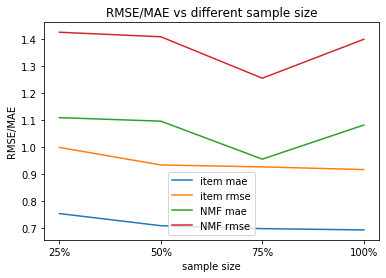

In [288]:
fig, ax = plt.subplots()
ax.plot(sample_size, item_model_mae, label='item mae');
ax.plot(sample_size, item_model_rmse, label='item rmse');
ax.plot(sample_size, NMF_model_mae, label='NMF mae');
ax.plot(sample_size, NMF_model_rmse, label='NMF rmse');
ax.set_title('RMSE/MAE vs different sample size')
ax.set_xlabel('sample size')
ax.set_ylabel('RMSE/MAE')
ax.legend();

- According to the results above, the overall test accuracy of both models change as the sampling size increases.

- For item-based neighborhood model, both test RMSE and MAE decrease(monitonically) as the samping size increases.

- For NMF model, both test RMSE and MAE reach their minimum at 75% sampling size but slightly increase as the sampling size approaches 100%.

### Part 6.6: What about the distribution of accuracy over users or items?

**Explanation: [ ]**

### Part 6.7: How does run-time scale with data size?

In [289]:
sample_size = ['25%', '50%', '75%', '100%']

In [290]:
item_model_fit_time = [item_model_25_fit_time, 
                       item_model_50_fit_time,
                       item_model_75_fit_time, 
                       item_model_100_fit_time]

item_model_test_time = [item_model_25_test_time, 
                        item_model_50_test_time,
                        item_model_75_test_time, 
                        item_model_100_test_time]

In [291]:
NMF_model_fit_time = [NMF_model_25_fit_time, 
                      NMF_model_50_fit_time,
                      NMF_model_75_fit_time, 
                      NMF_model_100_fit_time]

NMF_model_test_time = [NMF_model_25_test_time, 
                       NMF_model_50_test_time,
                       NMF_model_75_test_time, 
                       NMF_model_100_test_time]

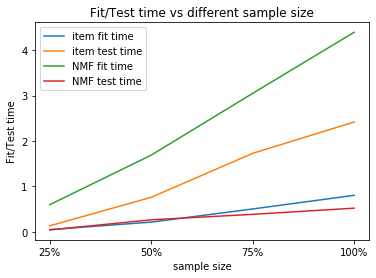

In [292]:
fig, ax = plt.subplots()
ax.plot(sample_size, item_model_fit_time, label='item fit time');
ax.plot(sample_size, item_model_test_time, label='item test time');
ax.plot(sample_size, NMF_model_fit_time, label='NMF fit time');
ax.plot(sample_size, NMF_model_test_time, label='NMF test time');
ax.set_title('Fit/Test time vs different sample size')
ax.set_xlabel('sample size')
ax.set_ylabel('Fit/Test time')
ax.legend();

- According to the results above, both fit time and test time of NMF and item-based models increase as the sampling size increases.

- Especially for NMF, the increase of fit time of NMF is almost proportional to the increase of sampling size.

## Part 7: How does your recommendation system meet your hypothetical objectives? Would you feel comfortable putting these solutions into production at a real company? What would be the potential watch outs?

**Explanation: [ ]**

## Part 8: Final remarks

**Explanation: [ ]**